In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv("librossa_features.csv")
X = df.drop("emotion", axis=1).values
y = df["emotion"].values

# 2) Split (optional hold-out)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1
)

X_train = pd.DataFrame(X_train, columns=df.columns[:-1])
X_test = pd.DataFrame(X_test, columns=df.columns[:-1])
y_train = pd.Series(y_train, name="emotion")
y_test = pd.Series(y_test, name="emotion")

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)


In [3]:

class InfoGainSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.045, random_state=42):
        self.threshold = threshold
        self.random_state = random_state

    def fit(self, X, y):
        # compute “info gain” scores per feature
        self.scores_ = mutual_info_classif(X, y, random_state=self.random_state)
        # build a boolean mask of features to keep
        self.mask_ = self.scores_ >= self.threshold
        if not np.any(self.mask_):
            raise ValueError(
                f"No features passed the threshold={self.threshold}"
            )
        return self

    def transform(self, X):
        # slice columns
        return X[:, self.mask_]

    def get_support(self):
        return self.mask_

    def get_feature_scores(self):
        return self.scores_

# 3) Define base learners with roughly the same hyperparameters
mlp = MLPClassifier(
    hidden_layer_sizes=(len(df.columns)-1,),  # “t” hidden units in Weka = #attributes
    learning_rate_init=0.03,   # -L 0.03
    momentum=0.2,              # -M 0.2
    max_iter=500,              # -N 500
    tol=1e-4,                  # stopping tolerance
    random_state=0,
)

rf_plain = RandomForestClassifier(
    n_estimators=100,          # -I 100
    min_samples_leaf=1,        # -M 1.0 (no min)
    random_state=1,
    n_jobs=1
)

# Weka’s MultiClassClassifier wraps RF for true multiclass; in sklearn:
rf_ovr = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=100,
        random_state=1
    ),
    n_jobs=1
)

# 4) Meta-learner: LogisticRegression with a tiny ridge (-R 1e-8 => C=1e8)
meta = LogisticRegression(
    C=1e8,
    solver="lbfgs",
    class_weight={0:1, 1:3, 2:7}, 
    max_iter=1000,
    multi_class="ovr",
    random_state=1
)

# 5) Build the stacking pipeline
stack = StackingClassifier(
    estimators=[
        ("mlp", mlp),
        ("rf_ovr", rf_ovr),
        ("rf", rf_plain),
    ],
    final_estimator=meta,
    cv=3,            # internal folds for generating meta-features
    n_jobs=1,        # -num-slots 1
    passthrough=False
)

pipeline = make_pipeline(
    SelectKBest(score_func=mutual_info_classif, k=63),
    StandardScaler(),
    SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=5),  # oversample the minority class
    stack,
)


              precision    recall  f1-score   support

    negative       0.89      0.79      0.84       263
     neutral       0.78      0.86      0.82        97
    positive       0.52      0.68      0.59        65

    accuracy                           0.79       425
   macro avg       0.73      0.77      0.75       425
weighted avg       0.81      0.79      0.79       425



c:\Users\jbkee\Desktop\Jupyter-Projects\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


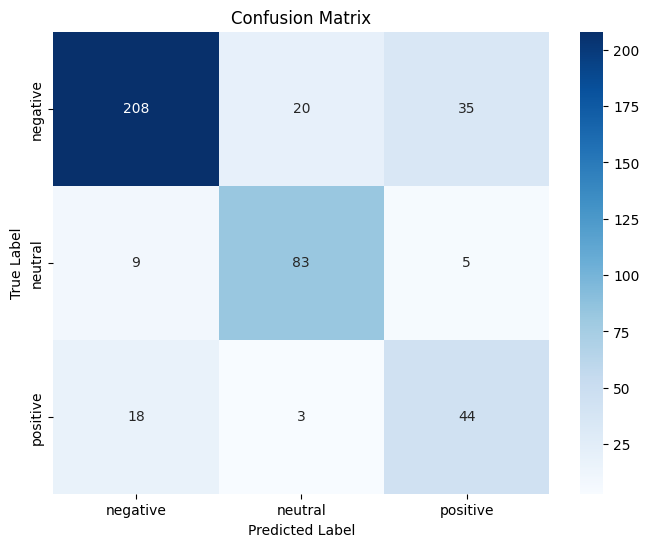

['ser_stacking.pkl']

In [4]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["negative","neutral","positive"],
    yticklabels=["negative","neutral","positive"]
    )
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

joblib.dump(pipeline, "ser_stacking.pkl")


In [5]:
df_emo = pd.read_csv("librossa_features_emo.csv")
X_emo = df_emo.drop("emotion", axis=1).values
y_emo = df_emo["emotion"].values

labels = df_emo["emotion"].unique()

# 2) Split (optional hold-out)
X_train_emo, X_test_emo, y_train_emo, y_test_emo = train_test_split(
    X_emo, y_emo, stratify=y_emo, test_size=0.2, random_state=1
)

X_train_emo = pd.DataFrame(X_train_emo, columns=df_emo.columns[:-1])
X_test_emo = pd.DataFrame(X_test_emo, columns=df_emo.columns[:-1])
y_train_emo = pd.Series(y_train_emo, name="emotion")
y_test_emo = pd.Series(y_test_emo, name="emotion")

X_train_emo.to_csv("X_train_emo.csv", index=False)
X_test_emo.to_csv("X_test_emo.csv", index=False)
y_train_emo.to_csv("y_train_emo.csv", index=False)
y_test_emo.to_csv("y_test_emo.csv", index=False)

In [6]:
pipeline_emo = make_pipeline(
    SelectKBest(score_func=mutual_info_classif, k=80),
    StandardScaler(),
    SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=5),  # oversample the minority class
    stack,
)

              precision    recall  f1-score   support

       angry       0.89      0.66      0.76        64
     disgust       0.55      0.64      0.59        47
     fearful       0.37      0.85      0.51        52
       happy       0.76      0.30      0.43        53
    negative       0.80      0.73      0.76        48
     neutral       0.75      0.68      0.71        59
    positive       0.64      0.58      0.61        12
         sad       0.77      0.53      0.63        51

    accuracy                           0.62       386
   macro avg       0.69      0.62      0.63       386
weighted avg       0.70      0.62      0.63       386



c:\Users\jbkee\Desktop\Jupyter-Projects\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


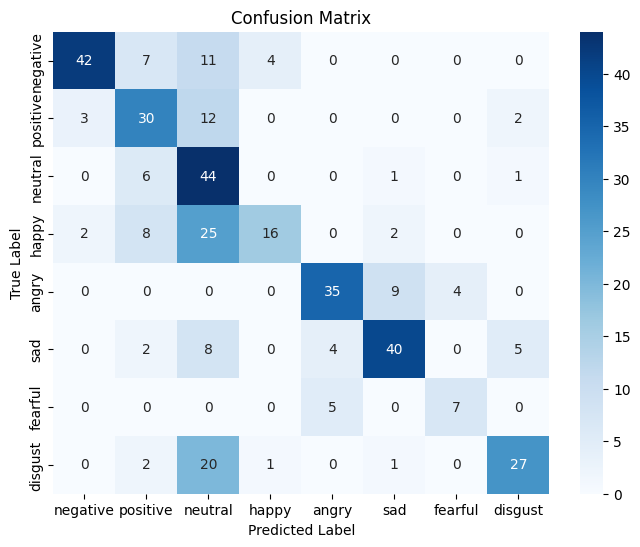

['ser_stacking_emo.pkl']

In [7]:
pipeline_emo.fit(X_train_emo, y_train_emo)
y_pred_emo = pipeline_emo.predict(X_test_emo)
print(classification_report(y_test_emo, y_pred_emo))

cm_emo = confusion_matrix(y_test_emo, y_pred_emo)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_emo,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
    )
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

joblib.dump(pipeline_emo, "ser_stacking_emo.pkl")

In [8]:
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
#     # clone the pipeline so each fold starts fresh
#     pipe = clone(pipeline)
    
#     # fit on this fold’s train split
#     pipe.fit(X[train_idx], y[train_idx])
    
#     # predict on the held‐out split
#     y_pred = pipe.predict(X[test_idx])
#     y_true = y[test_idx]
    
#     print(f"\n=== Fold {fold} Classification Report ===")
#     print(classification_report(
#         y_true,
#         y_pred,
#         target_names=["negative","neutral","positive"],
#         digits=4
#     ))

In [9]:
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# scores = cross_val_score(
#     pipeline,
#     X, y,
#     cv=cv,
#     scoring="accuracy",
#     n_jobs=-1
# )
# print(f"Max: {scores.max():.3f}, Mean: {scores.mean():.3f}, Min: {scores.min():.3f}, Std: {scores.std():.3f}")